In [1]:
 !pip install opencv-python==4.4.0.42

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.4 MB 2.3 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import cv2
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import zipfile
print(cv2.__version__)

4.4.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#!wget https://pjreddie.com/media/files/yolov3-tiny.weights
#!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3-tiny.cfg
#!wget https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/coco.names
#!wget https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4-tiny.cfg

In [5]:
#path = '/content/drive/MyDrive/UTF/TCC/Projeto/yolov4-tiny_model.zip' 
#zip_object = zipfile.ZipFile(file=path, mode="r")
#zip_object.extractall("./")
#zip_object.close()

In [6]:
names_path = '/content/drive/MyDrive/Projeto TCC/approach_2/data/obj.names'
cfg_path = '/content/drive/MyDrive/Projeto TCC/approach_2/cfg/yolov4_custom.cfg'
weights_path = '/content/drive/MyDrive/Projeto TCC/approach_2/cfg/yolov4_custom_best.weights'
names_list = open(names_path).read().strip().split('\n')

In [7]:
print(names_list)

['Com Capacete', 'Sem Capacete']


In [8]:
net = cv2.dnn.readNet(cfg_path, weights_path) # Definindo configurações rede neural a partir da arquivos de configuração
COLORS = np.array([[0, 255, 0], [0, 0, 255]]) # Montando lista de cores para cada tipo de objeto detectado na imagem
print(COLORS)

[[  0 255   0]
 [  0   0 255]]


In [9]:
ln = net.getLayerNames() # Coletando quantidade de variáveis da rede
print('Todas as camadas')
print(ln)
print('Total de Camadas: ' + str(len(ln)))
print('Camadas de saída')
print(net.getUnconnectedOutLayers())
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()] #nome das camadas
ln

Todas as camadas
['conv_0', 'bn_0', 'mish_1', 'conv_1', 'bn_1', 'mish_2', 'conv_2', 'bn_2', 'mish_3', 'identity_3', 'conv_4', 'bn_4', 'mish_5', 'conv_5', 'bn_5', 'mish_6', 'conv_6', 'bn_6', 'mish_7', 'shortcut_7', 'conv_8', 'bn_8', 'mish_9', 'concat_9', 'conv_10', 'bn_10', 'mish_11', 'conv_11', 'bn_11', 'mish_12', 'conv_12', 'bn_12', 'mish_13', 'identity_13', 'conv_14', 'bn_14', 'mish_15', 'conv_15', 'bn_15', 'mish_16', 'conv_16', 'bn_16', 'mish_17', 'shortcut_17', 'conv_18', 'bn_18', 'mish_19', 'conv_19', 'bn_19', 'mish_20', 'shortcut_20', 'conv_21', 'bn_21', 'mish_22', 'concat_22', 'conv_23', 'bn_23', 'mish_24', 'conv_24', 'bn_24', 'mish_25', 'conv_25', 'bn_25', 'mish_26', 'identity_26', 'conv_27', 'bn_27', 'mish_28', 'conv_28', 'bn_28', 'mish_29', 'conv_29', 'bn_29', 'mish_30', 'shortcut_30', 'conv_31', 'bn_31', 'mish_32', 'conv_32', 'bn_32', 'mish_33', 'shortcut_33', 'conv_34', 'bn_34', 'mish_35', 'conv_35', 'bn_35', 'mish_36', 'shortcut_36', 'conv_37', 'bn_37', 'mish_38', 'conv_38

['yolo_139', 'yolo_150', 'yolo_161']

In [10]:
# Definindo função para mostrar foto no Google Colab
def show(img):
  fig = plt.gcf()
  fig.set_size_inches(16,10)
  plt.axis('off')
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

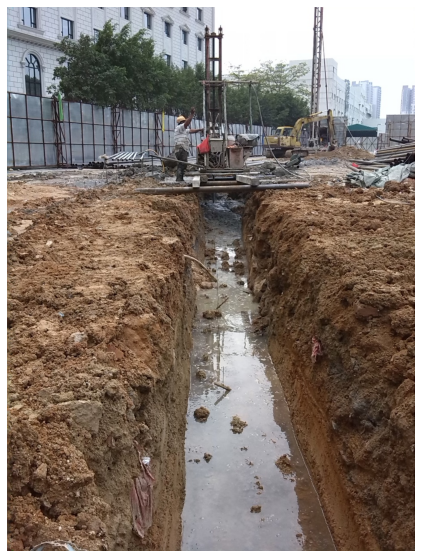

In [72]:
img = cv2.imread('/content/drive/MyDrive/Projeto TCC/images/pictor_ppe/image_from_china(328).jpg')
show(img)

In [73]:
img_cp = img.copy()
(h, w) = img.shape[:2] 
#print('Altura: ' + str(h) + '\nLargura: ' +  str(w))

inicio = time.time()

blob_image = cv2.dnn.blobFromImage(img, 1 / 255.0, (416,416), swapRB = True, crop = False)
net.setInput(blob_image)
layers_outputs = net.forward(ln)

termino = time.time()
print('YOLO levou {:.2f} segundos'.format(termino - inicio))

YOLO levou 1.48 segundos


# Detecção dos Objetos

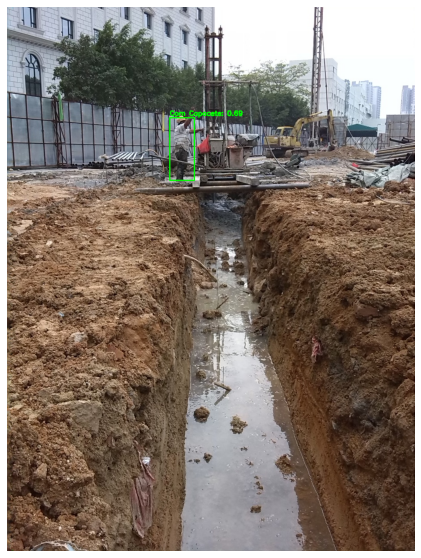

In [74]:
THRESHOLD = 0.5       #Valor constante para limiar da detecção
THRESHOLD_NMS = 0.3   #Valor constante para Non-Maximum Suppression
bounding_boxes = []   #Lista para para armazenar medidas do bounding boxes     
confidences = []      #Lista para armazenar confiança de cada classe 
IDclasses = []        #Lista para armazenar precição feita

for output in layers_outputs:
  for detection in output:
    scores = detection[5:]
    classID = np.argmax(scores)
    confidence = scores[classID]
    if confidence > THRESHOLD:
      #print(' Classe mais provável: ' + str(names_list[classID]))
      #print(' Confianca: ' + str(confidence))

      box = detection[0:4] * np.array([w, h, w, h])
      (centerX, centerY, width, height) = box.astype('int')

      x = int(centerX - (width/2))
      y = int(centerY - (height/2))

      bounding_boxes.append([x, y, int(width), int(height)])
      confidences.append(float(confidence))
      IDclasses.append(classID)
  
# Aplicando Non-Max-Suppression
objs = cv2.dnn.NMSBoxes(bounding_boxes, confidences, THRESHOLD, THRESHOLD_NMS)

if len(objs > 0):
  for i in objs.flatten():
    (x, y) = (bounding_boxes[i][0], bounding_boxes[i][1])
    (w, h) = (bounding_boxes[i][2], bounding_boxes[i][3])

    #objeto = img_cp[y:y+h, x:x+w]
    #cv2_imshow(objeto)

    cor = [int(c) for c in COLORS[IDclasses[i]]]

    cv2.rectangle(img, (x, y), (x + w, y+ h), cor, 2)
    text = '{}: {:.2f}'.format(names_list[IDclasses[i]], confidences[i])
    cv2.putText(img, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, cor, 2)
show(img)